**Collecting data of Google's Stock Price**

In [6]:
import pandas as pd
import yfinance as yf
import datetime
from datetime import date, timedelta

today = date.today()

d1 = today.strftime("%Y-%m-%d")
end_date = d1
d2 = date.today() - timedelta(days=365)
d2 = d2.strftime("%Y-%m-%d")
start_date = d2

data = yf.download('GOOG',
                      start=start_date,
                      end=end_date,
                      progress=False)

data["Date"] = data.index
data = data[["Date", "Open", "High", "Low",
             "Close", "Adj Close", "Volume"]]
data.reset_index(drop=True, inplace=True)
print(data.tail())

          Date        Open        High         Low       Close   Adj Close  \
246 2024-10-14  164.910004  167.619995  164.779999  166.350006  166.350006   
247 2024-10-15  167.139999  169.089996  166.050003  166.899994  166.899994   
248 2024-10-16  166.029999  167.279999  165.216003  166.740005  166.740005   
249 2024-10-17  167.380005  167.929993  164.369995  164.509995  164.509995   
250 2024-10-18  164.869995  166.369995  164.750000  165.050003  165.050003   

       Volume  
246   9981800  
247  14829300  
248   9968500  
249  15113400  
250  13086900  


In [7]:
data = data[["Date", "Close"]]
print(data.head())

        Date       Close
0 2023-10-20  136.740005
1 2023-10-23  137.899994
2 2023-10-24  140.119995
3 2023-10-25  126.669998
4 2023-10-26  123.440002


**Visualising the close pricest**

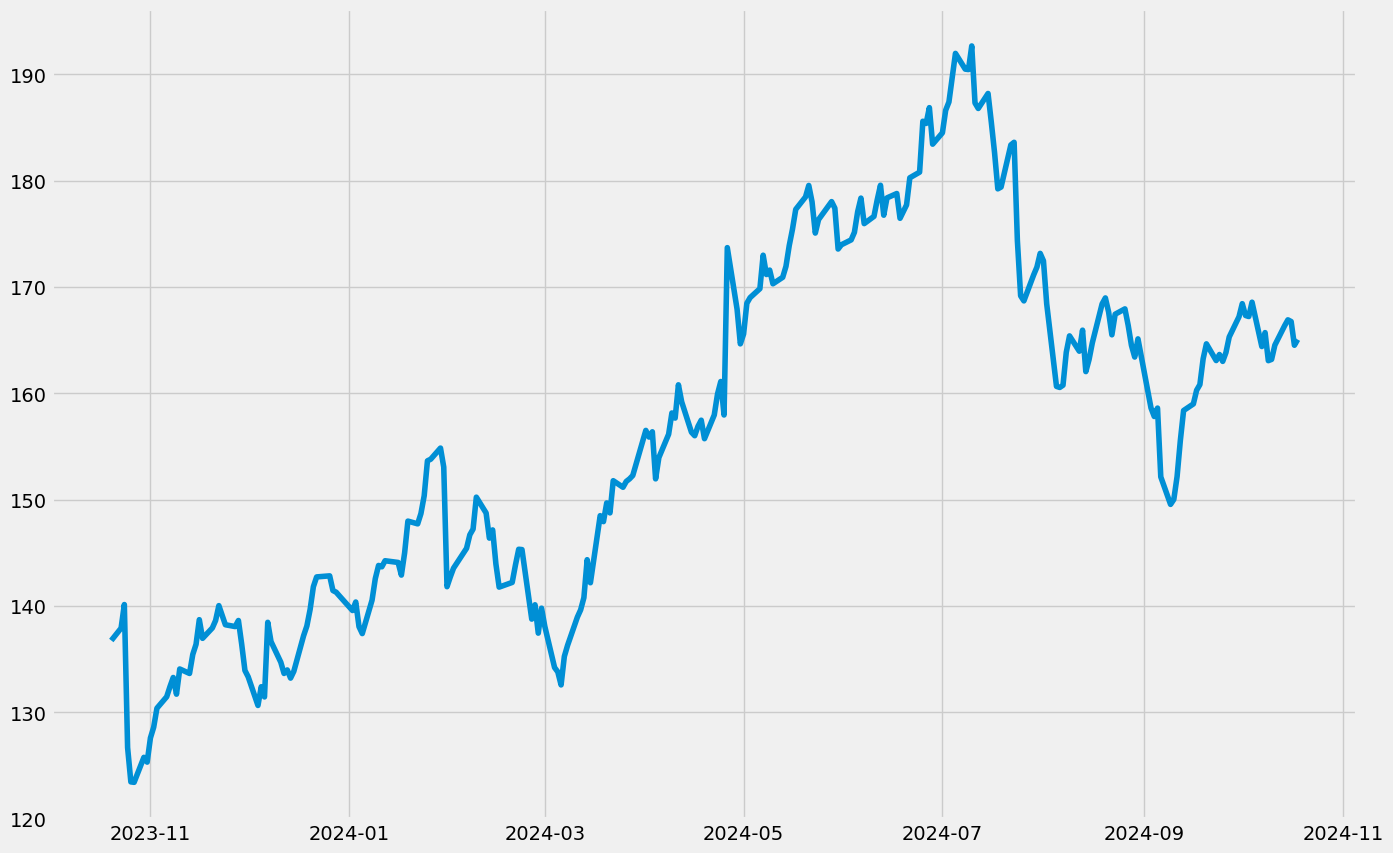

In [8]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15, 10))
plt.plot(data["Date"], data["Close"])

**Checking if our dataset is stationary or seasonal properly by using seasonal decompostion**

<Figure size 640x480 with 0 Axes>

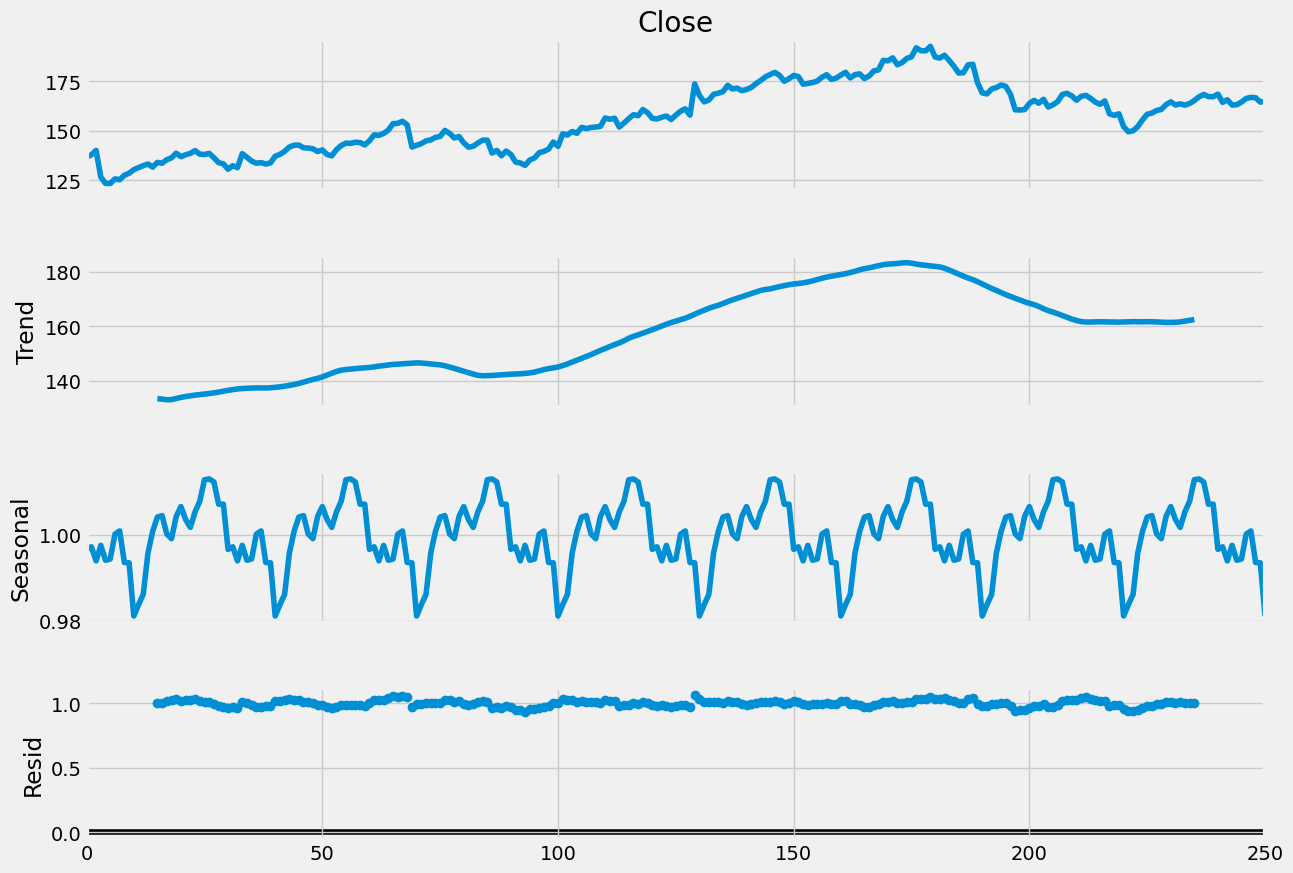

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data["Close"], model='multiplicative', period=30)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(15, 10)

**Since our data is seasonal we will use Seasonal ARIMA (SARIMA) model for Time Series Forecasting on this data**

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

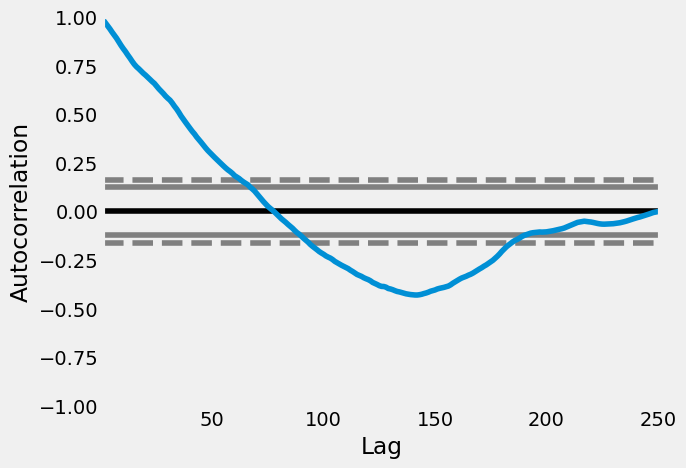

In [10]:
pd.plotting.autocorrelation_plot(data["Close"])

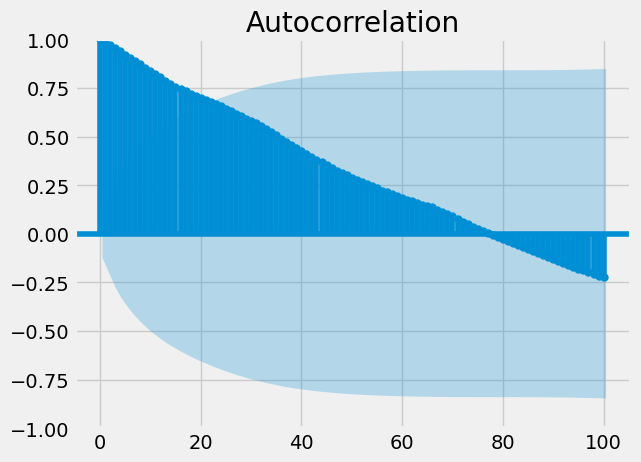

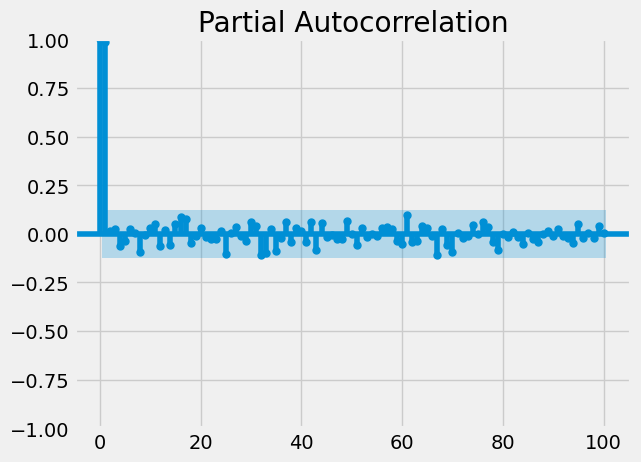

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data["Close"], lags=100)
plt.show()
plot_pacf(data["Close"], lags=100)
plt.show()

**building ARIMA model**

In [19]:
p, d, q = 5, 1, 2
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(data["Close"], order=(p, d, q))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  251
Model:                 ARIMA(5, 1, 2)   Log Likelihood                -595.938
Date:                Sat, 19 Oct 2024   AIC                           1207.875
Time:                        15:27:09   BIC                           1236.047
Sample:                             0   HQIC                          1219.213
                                - 251                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4996      0.059     -8.428      0.000      -0.616      -0.383
ar.L2         -0.9542      0.094    -10.190      0.000      -1.138      -0.771
ar.L3         -0.1004      0.112     -0.896      0.3

In [20]:
predictions = model_fit.predict()
print(predictions)

0        0.000000
1      136.739999
2      137.892572
3      140.090035
4      126.641855
          ...    
246    165.845457
247    166.299152
248    165.881624
249    167.105461
250    165.040769
Name: predicted_mean, Length: 251, dtype: float64


**The predicted values are wrong because the data is seasonal. ARIMA model does not perform well on seasonal time series data. So, now we will build SARIMA model**

In [21]:
import statsmodels.api as sm
import warnings
model = sm.tsa.statespace.SARIMAX(data["Close"], order=(p, d, q), seasonal_order=(p, d, q, 12))
model = model.fit()
print(model.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                  251
Model:             SARIMAX(5, 1, 2)x(5, 1, 2, 12)   Log Likelihood                -581.790
Date:                            Sat, 19 Oct 2024   AIC                           1193.580
Time:                                    15:32:36   BIC                           1245.664
Sample:                                         0   HQIC                          1214.571
                                            - 251                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6229      0.085      7.360      0.000       0.457       0.789
ar.L2         -0.9480      0.094   

**Predicting future stock prices using SARIMA model for next 10 days**

In [22]:
predictions = model.predict(len(data), len(data)+10)
print([predictions])

[251    166.027678
252    166.725633
253    168.748547
254    169.032358
255    167.934631
256    167.936320
257    169.476367
258    170.243045
259    171.401181
260    170.846101
261    170.559911
Name: predicted_mean, dtype: float64]


<Axes: >

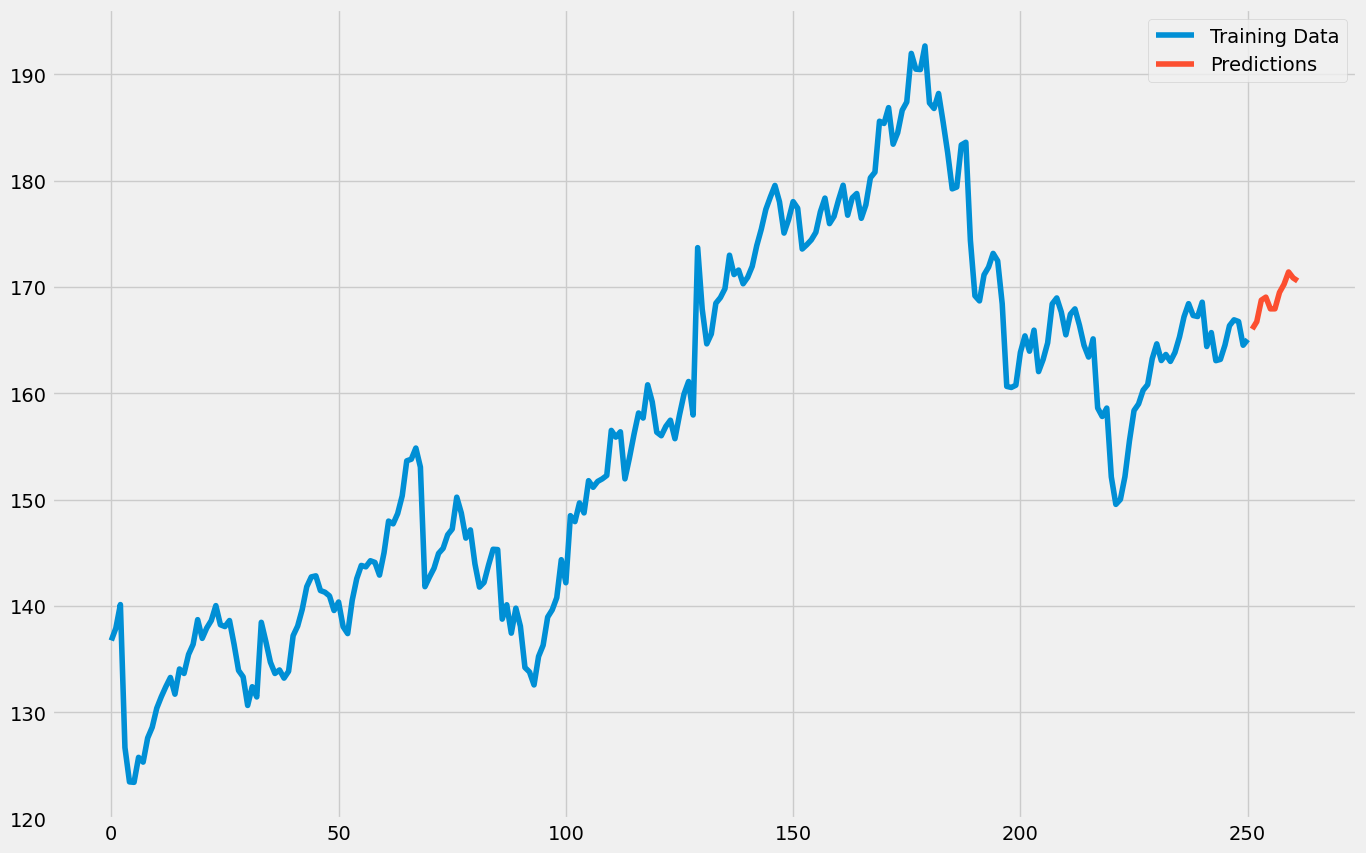

In [23]:
data["Close"].plot(legend=True, label="Training Data", figsize=(15, 10))
predictions.plot(legend=True, label="Predictions")